In [3]:
import torch
import numpy as np
import pandas as pd
import os
import math
from dataset import Custom_Dataset
from torch.utils.data import DataLoader
from glob import glob
from tqdm import tqdm
from time import time
import random
import yaml
import cv2
from metrics import meanIoU, f1_score
from models import get_model
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%load_ext autoreload
%autoreload 2
root_path = r'C:\Users\taesh\cwc'
height = 384
width =384
num_classes = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path = os.path.join(root_path, "dataset", "new_dataset")
test_1_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
test_1_y = sorted(glob(os.path.join(path, "test", "mask", "*.npy")))
#test_2_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
#test_2_y = sorted(glob(os.path.join(path, "test", "mask", "*.npy")))
print(len(test_1_x))
print(len(test_1_y))

100
100


In [11]:
model_path = glob(os.path.join(root_path, "results", "dataset_1700", "Unet3Plus", "drop_expanded_rotate_discrete_noise_005", "*", "*"))

model_path = glob(os.path.join(root_path, "results", "dataset_1700", "Unet", "drop_expanded_discrete", "*", "*"))
model_paths = list()
except_list = [
    '20240508_144424',
    '20240515_103138'
]
for path in model_path:
    if path.split("\\")[-1] in except_list or path.split('\\')[-2][:2] == 'ex':
        continue
    model_paths.append(path)
model_paths

['C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_0\\20240411_230051',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_0\\20240412_073542',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_0\\20240412_172329',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_1\\20240413_145746',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_1\\20240413_235221',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_1\\20240414_084344',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_2\\20240414_175630',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_2\\20240415_012333',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_2\\20240415_100703',
 'C:\\Users\\taesh\\cwc\\results\\dataset_1700\\Unet\\drop_expanded_discrete\\0_3\\20240415

In [12]:
def model_load(path, device):
    history = torch.load(os.path.join(path, "model.pt"), map_location=device)
    with open(os.path.join(path, 'setting.yaml'), 'r', encoding='UTF8') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    model = get_model(config["model_name"])
    model = model(**config["model_parameters"]).to(device)
    model.load_state_dict(history["model"])
    return model

#metric_func = get_metric("meanIoU")

In [13]:
test1_dataset = Custom_Dataset(
         data_path=test_1_x, label_path=test_1_y, size=(height, width), mode='test'
    )
test_1_dataloader = DataLoader(
    dataset=test1_dataset, batch_size=1, shuffle=True, drop_last=False
)

In [15]:
seed = 67
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [16]:
def train_model(path, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_load(path, device)
    
    model.eval()
    metric_score = 0.0
    metric_time = 0.0
    f1 = list()
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            tic = time()
            y_pred = model(x)
            toc = time()
            metric_time += 1/(toc-tic)
            metric_score += meanIoU(y_pred, y)
            f1.append(f1_score(y_pred, y).cpu())
            
    score = float(torch.round(metric_score/len(dataloader), decimals=4))
    metric_time = float(round(metric_time/len(dataloader), ndigits=4))
    f1 = np.array(f1).mean()
    
    return score, metric_time, f1

In [17]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [18]:
score_list = list()
name_list = list()
time_list = list()
for path in model_paths:
    score, metric_time, f1 = train_model(path, test_1_dataloader)
    with open(os.path.join(path, 'setting.yaml'), 'r', encoding='UTF8') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    path = path.split("\\")
    name_list.append("{}_{}_{}_time:{}_miou:{}_f1:{}".format( path[-3],
        path[-2], -math.log10(config['minimum_learning_rate']) if config['minimum_learning_rate'] > 0 else 0 ,
        metric_time, score, f1
                                                             
    ))
    print(score)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


0.7706999778747559


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.37it/s]


0.761900007724762


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.46it/s]


0.7609999775886536


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]


0.6909999847412109


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.43it/s]


0.7626000046730042


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.48it/s]


0.7663000226020813


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.94it/s]


0.7627000212669373


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.54it/s]


0.7578999996185303


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.53it/s]


0.7470999956130981


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.50it/s]


0.07410000264644623


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.34it/s]


0.08380000293254852


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.46it/s]


0.07360000163316727


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.23it/s]


0.0835999995470047


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.67it/s]


0.7452999949455261


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.47it/s]


0.06939999759197235


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.41it/s]


0.11699999868869781


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.41it/s]


0.7567999958992004


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.46it/s]


0.7573000192642212


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


0.7511000037193298


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]


0.7509999871253967


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.35it/s]


0.7498000264167786


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.23it/s]


0.741100013256073


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.43it/s]


0.7123000025749207


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.84it/s]


0.7451000213623047


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.43it/s]


0.7527999877929688


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.60it/s]


0.7462999820709229


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.34it/s]


0.7317000031471252


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.51it/s]


0.7444000244140625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.41it/s]


0.7285000085830688


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.47it/s]


0.7314000129699707


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.52it/s]


0.08060000091791153


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.47it/s]


0.718999981880188


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.30it/s]


0.7080000042915344


In [29]:
for line in name_list:
    tmp = line.split(':')
    print("{}: miou:{:.4f} f1:{:.4f}".format(tmp[0][23:28], float(tmp[2][:7]), float(tmp[-1][:7])))
    

0_0_6: miou:0.7707 f1:0.8236
0_0_7: miou:0.7619 f1:0.8156
0_0_0: miou:0.7610 f1:0.8160
0_1_6: miou:0.6910 f1:0.7629
0_1_7: miou:0.7626 f1:0.8155
0_1_0: miou:0.7663 f1:0.8188
0_2_6: miou:0.7627 f1:0.8175
0_2_7: miou:0.7579 f1:0.8114
0_2_0: miou:0.7471 f1:0.8028
0_3_6: miou:0.0741 f1:0.0803
0_3_7: miou:0.0838 f1:0.0959
0_3_0: miou:0.0736 f1:0.0785
0_4_6: miou:0.0836 f1:0.0963
0_4_7: miou:0.7453 f1:0.8029
0_4_0: miou:0.0694 f1:0.0764
1_2_6: miou:0.1170 f1:0.1476
1_2_7: miou:0.7568 f1:0.8121
1_2_0: miou:0.7573 f1:0.8120
1_3_6: miou:0.7511 f1:0.8070
1_3_7: miou:0.7510 f1:0.8064
1_3_0: miou:0.7498 f1:0.8059
1_4_6: miou:0.7411 f1:0.7978
1_4_7: miou:0.7123 f1:0.7756
1_4_0: miou:0.7451 f1:0.8027
2_3_6: miou:0.7528 f1:0.8090
2_3_7: miou:0.7463 f1:0.8032
2_3_0: miou:0.7317 f1:0.7924
2_4_6: miou:0.7444 f1:0.8044
2_4_7: miou:0.7285 f1:0.7888
2_4_0: miou:0.7314 f1:0.7924
3_4_6: miou:0.0806 f1:0.0864
3_4_7: miou:0.7190 f1:0.7824
3_4_0: miou:0.7080 f1:0.7712


In [90]:
score_df = pd.DataFrame([score_list, time_list]).T
score_df.index = name_list
score_df.to_csv(os.path.join(root_path, "results", "dataset_1700", "Unet", "drop_expanded_discrete", "test1_result.csv"))

In [105]:
v0 = pd.read_csv(os.path.join(root_path, "results", "dataset_1700", "Unet", "drop_expanded_discrete", "test1_result.csv"))
v1 = pd.read_csv(os.path.join(root_path, "results", "dataset_1700", "Unet", "drop_expanded_discrete", "test1_result_v1.csv"))

In [116]:
path = os.path.join(r'C:\Users\taesh\cwc\results\dataset_1700\Unet\no_drop\0_0\20240327_192944_')
s, t = train_model(path, test_1_dataloader)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


In [5]:
img = cv2.imread(test_1_x[0])
img = cv2.resize(img, (height, width))
img = img.transpose(2, 0, 1)
img = torch.Tensor(img)
cls = np.load(test_1_y[0])
cls = cv2.resize(cls, (height, width))
cls = torch.Tensor(cls)
cls = cls.permute(2, 0, 1)

In [64]:
top, left, right, bot = (100, 0, 0, 100)
assert top == -100 or top==100, top

In [55]:
e_img = F.crop(img, top, left, height, width)/255
e_cls = F.crop(cls, top, left, height, width)`a
if top<0:
    e_cls[0,:-top,:]=1
elif top>0:
    e_cls[0, -top:,:]=1
if left<0:
    e_cls[0,:,:-left]=1
elif left>0:
    e_cls[0,:,-left:]=1

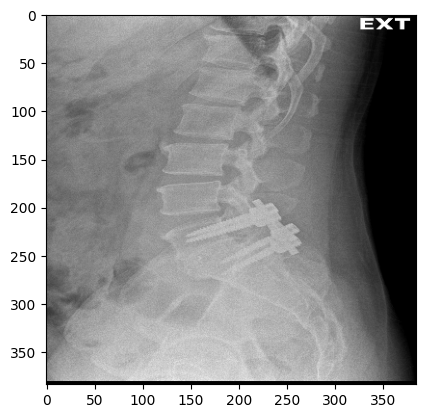

In [56]:
plt.imshow(img.permute(1, 2, 0)/255)

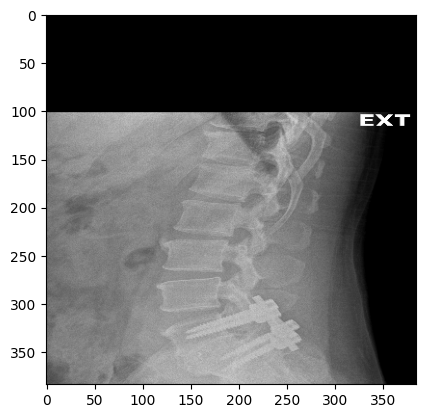

In [57]:
plt.imshow(e_img.permute(1, 2, 0))

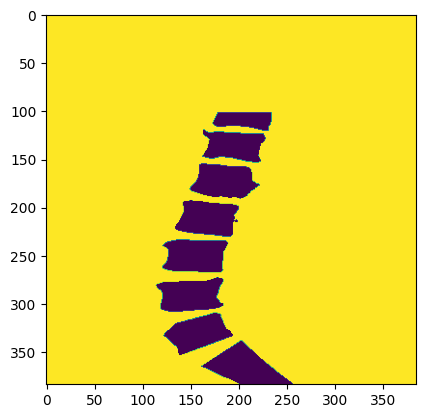

In [58]:
plt.imshow(e_cls[0])

In [52]:
a = 3
a *= random.choice([-1, 1])
print(a)

-3
